In [1]:
import sqlite3
from sqlite3 import Error

import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
sns.set_palette('gist_earth_r',n_colors=8)
import matplotlib.pyplot as plt

# # Modeling
# from sklearn.model_selection import train_test_split,GridSearchCV
# from sklearn.compose import ColumnTransformer
# from sklearn.preprocessing import MinMaxScaler,OneHotEncoder

# from imblearn.over_sampling import SMOTE
# import xgboost as xgb
# from sklearn.metrics import classification_report, roc_curve,auc, confusion_matrix

import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
def read_data_from_DB():
    try:
        path_to_DB = r"../Data/house.db"
        conn = sqlite3.connect(path_to_DB)
        df = pd.read_sql_query("SELECT * from house_features", conn)
    except Error as e:
        print(e)
        df = 0
    return df
df = read_data_from_DB()

In [3]:
df.head(5)


,ID,HOUSE_TYPE,HOUSE_ROOMS,ADDRESS,AREA,CITY,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE
0,1,Kerrostalo,2 h + k,Mechelininkatu 17 A,Töölö,Helsinki,575000,81,1928,60.172709,24.920025
1,2,Kerrostalo,1h + kk + kph + lasitettu parveke,Porvoonkatu 5-7 A,Alppiharju,Helsinki,209000,28,1963,60.189479,24.950852
2,3,Omakotitalo,"3-4h, k, rh, 2wc, kuisti n. 115 m2 + saunaos....",Lainlukijantie 42,Torpparinmäki,Helsinki,398000,115,1954,60.263987,24.954653
3,4,Kerrostalo,1 h + kk + kph,Kauppalantie 13,Etelä-Haaga,Helsinki,199000,26,1963,60.211790,24.898284
4,5,Kerrostalo,2H + KK + S,Leikosaarentie 13,Vuosaari,Helsinki,16446,46,1996,60.202981,25.142185


Helsinki city center is quite large, but the if someone would have to point out *the* central point, they would either say "Narinkkatori" or "Kolmen sepän patsas".
I want to measure the distance between Narinkkatori and the listed house/apartment. My hypothesis is that the further away the location is from this central point, the less it will be valued.

The distance could be computed in various ways, but as we are possibly dealing with small distances ( $d<1$ km), we need to be careful when selecting the correct distance computation method.

Let $\lambda_1$,$\phi_1$ and $\lambda_2$,$\phi_2$ be the geographical longitude and latitude of two points 1 and 2, and $\Delta\lambda$,$\Delta\phi$ be their absolute differences. R is the radius of the earth (6371km)

We could use the spherical law of cosines:
- $d = R \cdot arccos(sin\phi_1sin\phi_2+cos\phi_1 cos\phi_2cos(\Delta\lambda)))$, but this is susceptible to rounding point errors.

A better alternative would be the Haversine formula:
- $d = archav(hav(\Delta\phi)+(1-hav(\Delta\phi)-hav(\phi_1+\phi_2))\cdot hav(\Delta\lambda))$,
- $hav(x) = sin^2(x/2)$

The simplest method would be a spherical projection onto a plane:
- $d = R\sqrt{(\Delta\phi)^2+(cos(\frac{\phi_1+\phi_2}{2})\Delta\lambda)^2}$



In [4]:
def compute_dist(lat1,lon1,lat2,lon2,dist="Spherical_to_plane"): #phi,lambda
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    if dist == "Spherical_to_plane":
        dist = 6371*np.sqrt((lat1-lat2)**2+(np.cos((lat1+lat2)/2)*(lon1-lon2)**2))
    elif dist == "Haversine":
        dlon = lon2 - lon1 
        dlat = lat2 - lat1 
        a = (np.sin(dlat/2)**2 
         + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2)
        c = 2 * np.arcsin(np.sqrt(a)) 
        dist = 6371 * c
    return dist

In [5]:
print("With a projection of spherical coordinates to a plane: ",compute_dist(60.172709,24.920025,60.263987,24.954653))
print("With a the Haversine formula: ",compute_dist(60.172709,24.920025,60.263987,24.954653,dist="Haversine"))

With a projection of spherical coordinates to a plane:  10.506161724677145
With a the Haversine formula:  10.328266143722727


The Haversine formula probably gives better approximations in our case, as it does not overshoot the distance due to a projection. In the future we might want to add listings from cities far away from the capital area, and thus Haversine still would be able to give decent approximations.

In [6]:
coords_narinkkatori = 60.169673, 24.934854
# compute_dist(62.617156,29.716200,*coords_narinkkatori,dist="Haversine")
df["DIST_to_center"] = compute_dist(df["LATITUDE"],df["LONGITUDE"],*coords_narinkkatori,dist="Haversine")
df.head()

,ID,HOUSE_TYPE,HOUSE_ROOMS,ADDRESS,AREA,CITY,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
0,1,Kerrostalo,2 h + k,Mechelininkatu 17 A,Töölö,Helsinki,575000,81,1928,60.172709,24.920025,0.886916
1,2,Kerrostalo,1h + kk + kph + lasitettu parveke,Porvoonkatu 5-7 A,Alppiharju,Helsinki,209000,28,1963,60.189479,24.950852,2.373312
2,3,Omakotitalo,"3-4h, k, rh, 2wc, kuisti n. 115 m2 + saunaos....",Lainlukijantie 42,Torpparinmäki,Helsinki,398000,115,1954,60.263987,24.954653,10.544124
3,4,Kerrostalo,1 h + kk + kph,Kauppalantie 13,Etelä-Haaga,Helsinki,199000,26,1963,60.211790,24.898284,5.100788
4,5,Kerrostalo,2H + KK + S,Leikosaarentie 13,Vuosaari,Helsinki,16446,46,1996,60.202981,25.142185,12.045611


## Exploratory Data Analysis

### Quick data cleaning

In [52]:
df.nunique()

ID                5123
HOUSE_TYPE           7
HOUSE_ROOMS       1911
ADDRESS           4425
AREA               322
CITY                 2
PRICE             2587
SIZE               247
YEAR               132
LATITUDE          1909
LONGITUDE         1912
DIST_to_center    1912
dtype: int64

In [50]:
df.describe()

,ID,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
count,5123.000000,5.123000e+03,5123.000000,5123.000000,5123.000000,5123.000000,5123.000000
mean,2562.000000,3.918746e+05,69.637712,1922.699200,59.498026,24.553062,109.714792
std,1479.027045,3.495647e+05,44.116534,390.730156,6.878493,2.930704,801.690151
min,1.000000,0.000000e+00,12.000000,0.000000,-1.000000,-1.000000,0.138821
25%,1281.500000,2.280000e+05,44.000000,1976.000000,60.169571,24.732449,5.613297
50%,2562.000000,3.229000e+05,62.000000,2021.000000,60.189602,24.863569,9.454627
75%,3842.500000,4.578500e+05,83.000000,2022.000000,60.223192,24.961605,12.709800
max,5123.000000,9.300000e+06,670.000000,2024.000000,66.433223,29.813338,7160.644071


We know that:

- ID and the coordinates are not that useful in our analyses
- PRICE, SIZE,YEAR, and the coordinates have default values for missing data
- The distance to the center can be invalid (over 50km from the center are not in the capital area)

In [78]:
df = df.drop(columns=["ID"]) if "ID" in df.columns else df
df = df[(df['PRICE'] != 0) & (df['SIZE'] > 0) & (df['YEAR'] > 0) & (df['LATITUDE'] > 0) & (df['LONGITUDE'] > 0) & (df['DIST_to_center'] > 0)& (df['DIST_to_center'] < 50)]

In [79]:
df.describe()

,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
count,4.678000e+03,4678.000000,4678.000000,4678.000000,4678.000000,4678.000000
mean,3.906882e+05,69.561992,2001.699658,60.196801,24.860204,9.038187
std,3.414816e+05,42.830821,30.467546,0.033831,0.145662,4.844522
min,7.912000e+03,12.000000,1850.000000,60.119687,24.458702,0.138821
25%,2.250250e+05,44.000000,1982.000000,60.170290,24.743502,5.265110
50%,3.204500e+05,62.000000,2021.000000,60.189602,24.876344,8.968534
75%,4.613500e+05,83.750000,2023.000000,60.221989,24.959749,12.283678
max,9.300000e+06,670.000000,2024.000000,60.614934,25.236193,49.747271


### Features

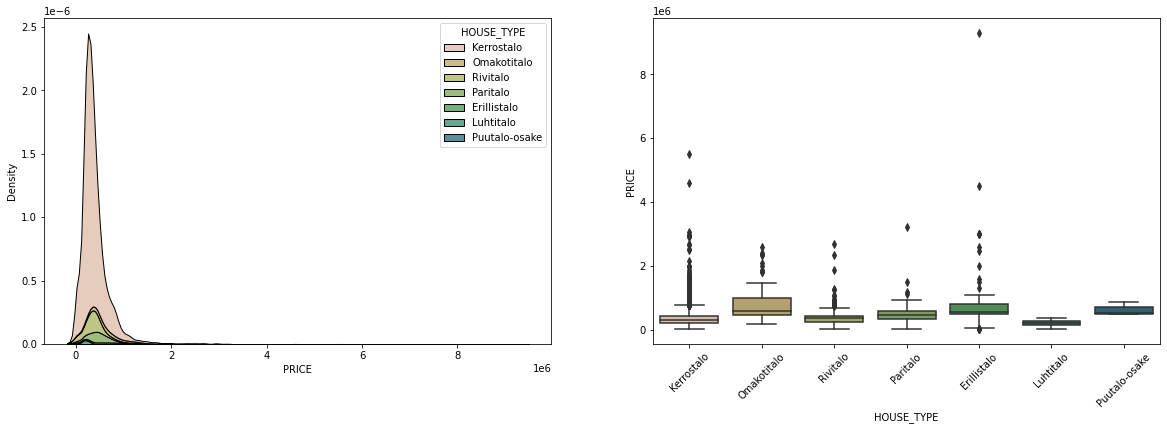

In [83]:
# num_cols = list(df.select_dtypes([np.number]).columns)
# cat_cols = [c for c in df.columns if c not in num_cols]

fig,ax = plt.subplots(nrows=1,ncols=2,figsize=(20, 6))
sns.kdeplot(hue=df["HOUSE_TYPE"], x=df['PRICE'],fill=True,multiple='stack',ax=ax[0]) 
sns.boxplot(x=df["HOUSE_TYPE"], y=df['PRICE'],ax=ax[1])
ax[1].xaxis.set_tick_params(labelrotation =45)
plt.show()

Erillistalo (detached house) and Omakotitalo (house) have the highest prices among the different house types.   
Kerrostalo (apartment house) type has the lest expensive listings.   
Let us see what the most expensive listings looks like:

In [81]:
df.nlargest(1, 'PRICE')

,HOUSE_TYPE,HOUSE_ROOMS,ADDRESS,AREA,CITY,PRICE,SIZE,YEAR,LATITUDE,LONGITUDE,DIST_to_center
921,Erillistalo,7h + k + 4kph + kht + 2var + tekn.var. + sivu...,Kuusiniementie 9,Kuusisaari,Helsinki,9300000,581,2020,60.187962,24.866627,4.28588


The most expensive listing is a huge (581 $m^2$) new (2020) house only 4km from the city center. It costs 9 300 000 €.

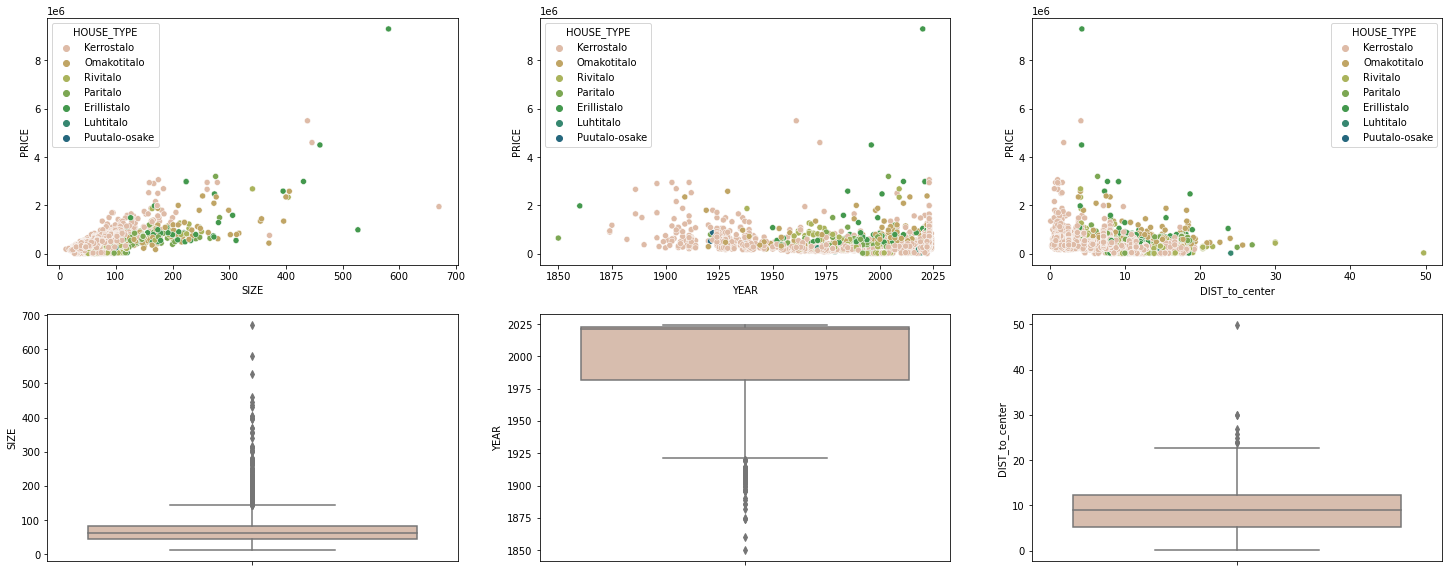

In [89]:
fig,ax = plt.subplots(nrows=2,ncols=3,figsize=(25, 10))
for i,col in enumerate(["SIZE","YEAR","DIST_to_center"]):
    sns.scatterplot(data=df,x=col, y='PRICE',hue='HOUSE_TYPE',ax=ax[0,i%3])
    sns.boxplot(data=df,y=col,ax=ax[1,i%3])
plt.show()

Larger houses are more expensive.   
The year when the house is built has a bimodal relationship with the price. There are new and old expensive houses, but no that many in the middle of the timeline.   
Distance to the center seems to be valued highly and thus the houses near the center are expensive


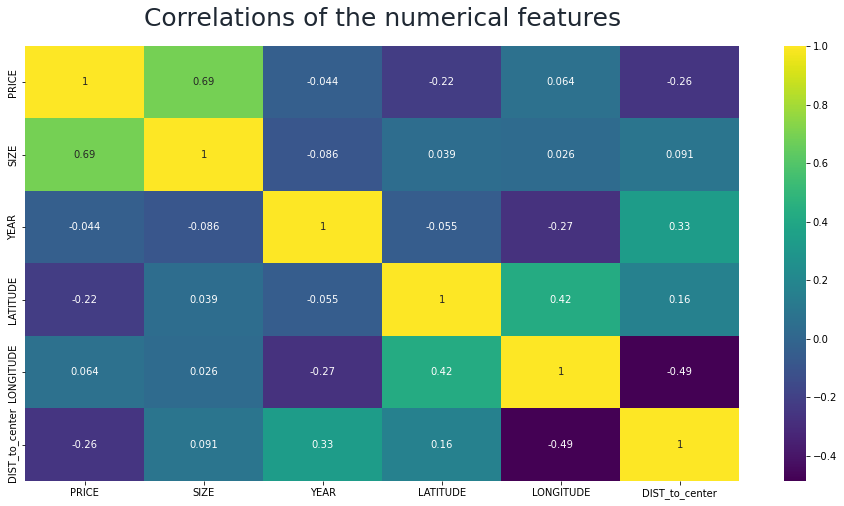

In [90]:
df_corr = df.corr()
plt.figure(figsize=[16,8])
plt.title("Correlations of the numerical features", size=25, pad=20, color='#1f2833')
sns.heatmap(df_corr, cmap="viridis", annot=True)
plt.show()

The size and the distance to the center seems to have highest correlations with the price of the listing.   
The distance to the center also has decent correlation with the year the house was built. This seems plausible as usually cities in Finland/Europe are built around and outwards from the oldest parts of the city. Helsinki centrum is mostly old building that have been renovated or left as is.  
The coordinates correlate with each other, and also with the distance to the center. This is obvious but we need to drop the coordinates later when implementing regression models to reduce multicollinearity

# TODO:

- Tähän map jossa (x,y) -coords, kokona price, värinä house type
- sns oma kartta plot jos on?

## Regression modeling

### Data preprocessing

### Baseline model

### Feature selection

### Model selection
cv scores

### Model tests and final evaluation